In [42]:
import matplotlib.pyplot as plt
from keras.models import model_from_json
import pandas as pd
pd.__version__
import tarfile
from tqdm.notebook import tqdm
import cv2
import os
import numpy as np
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import uuid


In [20]:
CODE_SIZE = 1000
DIM_X=100
DIM_Y=100

In [21]:
json_file = open('autoencoder_json.json', 'r')
autoencoder = model_from_json(json_file.read())

# loading weights of a keras model
autoencoder.load_weights('autoencoder_weights.h5')
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      4624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 8)         1160      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 8)         584   

In [80]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

def display(img, img_reco):
    ssim_none = ssim(img, img, data_range=img.max() - img.min(), multichannel=True)
    ssim_reco = ssim(img, img_reco, data_range=img_reco.max() - img_reco.min(), multichannel=True)

    label = 'Similarity Index: {:.2f}'

    plt.subplot(1,2,1)
    plt.title("Original")
    plt.xlabel(label.format(ssim_none))
    show_image(img)

    plt.subplot(1,2,2)
    plt.title("Reconstructed")
    plt.xlabel(label.format(ssim_reco))
    show_image(img_reco)
    plt.show()
    
    return (ssim_none, ssim_reco)
    
    
def load_image(filename, dimx=DIM_X, dimy=DIM_Y):
#     all_photos = []
    with open(filename, 'rb') as f:
        img = decode_image_from_raw_bytes(f.read())
        orig_height, orig_width, _ = img.shape
        orig_size = (orig_width, orig_height)
        
        img = cv2.resize(img, (dimx, dimy))
        new_height, new_width, _ = img.shape
        new_size = (new_width, new_height)
        
        return img, orig_size, new_size

def create_image_sample(img):
    all_photos = []
    all_photos.append(img)
    all_photos = np.stack(all_photos).astype('uint8')
    sample = all_photos.astype('float32') / 255.0 - 0.5
    return sample


In [ ]:
# TODO: get from argument

filename = sys.argv[1]

if not os.path.exists(filename):
    print("Error: file does not exist: "+filename)
    return 1

# filename = "C:/Users/Jhehey/fiftyone/caltech256/cartman/032_0020.jpg"
image, orig_size, new_size = load_image(filename)
X_sample = create_image_sample(image)
image_sample = X_sample[0]

show_image(image_sample)

# predict 
predictions = autoencoder.predict(X_sample)
image_predicted = predictions[0]

display(image_sample, image_predicted)



SyntaxError: EOL while scanning string literal (Temp/ipykernel_16644/1675577691.py, line 6)

results\540fdb647a6241ab96f79cefa0dffbe2


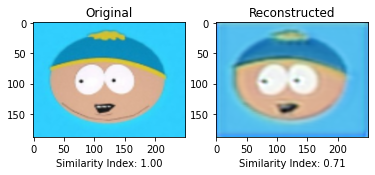

{'similarityIndex': 0.7120893988508876}


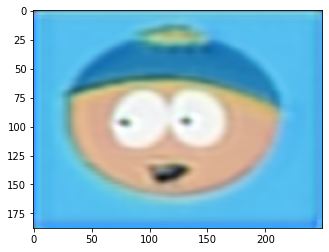

In [82]:
# save the image and write properties

# create folder
directory = os.path.join("results", uuid.uuid4().hex)
if not os.path.exists(directory):
    os.makedirs(directory)
    print(directory)

# resize to old image
encrypted_image = cv2.resize(image_sample, orig_size)
predicted_image = cv2.resize(image_predicted, orig_size)

ssim_orig, ssim_reco = display(encrypted_image, predicted_image)
show_image(predicted_image)

# save image
save_filename = os.path.join(directory, "predicted.jpg")
image_to_save = cv2.cvtColor((predicted_image + 0.5)*255, cv2.COLOR_RGB2BGR)
cv2.imwrite(save_filename, image_to_save)

# write properties
properties = {
  "similarityIndex": ssim_reco
}

print(properties)
